### Задание 1

**Retention** – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 
Функция должна быть написана на python. В ходе решения можно тестировать работу функции 
как на полном датасете, так и на части (сэмпле) данных.

In [1]:
import pandas as pd

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from datetime import datetime
import pingouin as pg
from scipy import stats
import scipy.stats as ss

### EDA

In [2]:
# данные о времени регистрации
reg_data  = pd.read_csv('problem1-reg_data.csv', sep=';')
reg_data

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
...,...,...
999995,1600874034,1110618
999996,1600874086,1110619
999997,1600874139,1110620
999998,1600874191,1110621


In [3]:
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [4]:
reg_data.duplicated().sum()

0

In [5]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [6]:
reg_data.isnull().sum()

reg_ts    0
uid       0
dtype: int64

In [7]:
# данные о времени захода пользователей в игру
auth_data = pd.read_csv('problem1-auth_data.csv', sep=';')
auth_data

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2
...,...,...
9601008,1600874034,1110618
9601009,1600874086,1110619
9601010,1600874139,1110620
9601011,1600874191,1110621


In [8]:
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [9]:
auth_data.isnull().sum()

auth_ts    0
uid        0
dtype: int64

In [10]:
auth_data.duplicated().sum()

0

In [11]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

#### Напишем функцию

In [12]:
def retention(reg_data, auth_data, start_date, final_date):
    start_date = pd.to_datetime(start_date)
    final_date = pd.to_datetime(final_date)

    reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.date
    auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.date

    full_data = reg_data.merge(auth_data, on='uid')
    full_data['reg_ts'] = pd.to_datetime(full_data['reg_ts'])
    full_data['auth_ts'] = pd.to_datetime(full_data['auth_ts'])
    full_data = full_data.loc[(full_data.reg_ts >= start_date) & (full_data.auth_ts <= final_date)]

    full_data['date_diff'] = (full_data['auth_ts'] - full_data['reg_ts']).dt.days
    
    full_data_pivot = full_data.pivot_table(index='reg_ts', columns='date_diff', values='uid', aggfunc='nunique')
    day_0 = full_data_pivot.iloc[:, 0]

    retention_rate = full_data_pivot.divide(day_0, axis=0)

    plt.figure(figsize = (20, 15))
    plt.title('Retention игроков по дням от даты регистрации, %', fontsize=30)
    ax = sns.heatmap(retention_rate, vmin=0.0, vmax=0.12,
                cmap='RdYlGn', linewidths=1, linecolor='black',
                fmt='.2%', annot=True)
    plt.ylabel('Дата регистрации', fontsize=25) 
    plt.xlabel('Кол-во дней после регистрации', fontsize=25)
    plt.show()

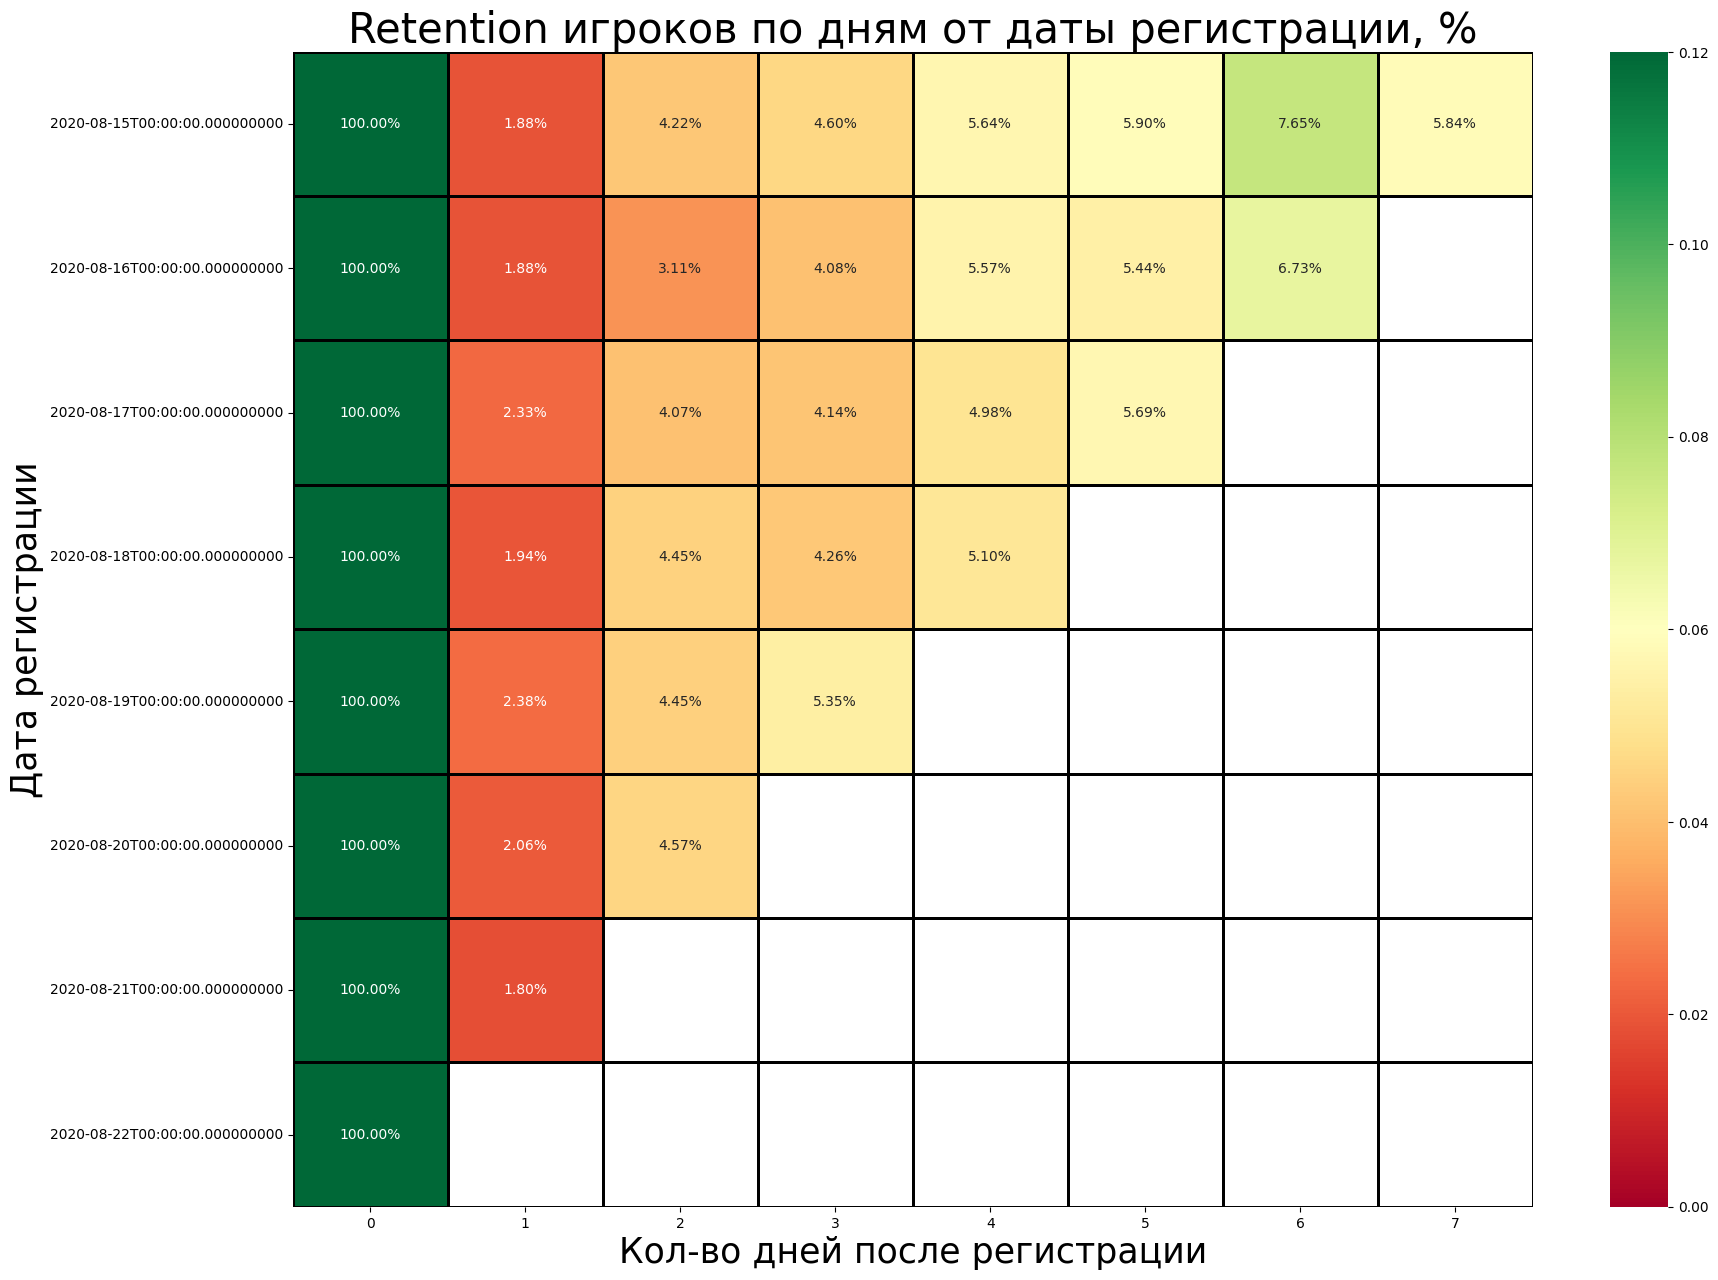

In [13]:
retention(reg_data, auth_data, '2020-08-15', '2020-08-22')

### Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.
1. Какой набор предложений можно считать лучшим? 
2. Какие метрики стоит проанализировать для принятия правильного решения и как?

Воспользуемся следующими метриками для анализа:
1) Cравним конверсию в покупку в разрезе групп и проверим статистическую значимость с помощью хи-квадрат.
2) Сравним ARPU в разрезе групп и проверим статистическую значимость с помощью тестов
3) Сравним ARPPU в разрезе групп и проверим статистическую значимость с помощью тестов

In [14]:
df = pd.read_csv('Проект_1_Задание_2.csv', sep =';')
df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [16]:
df.duplicated().sum()

0

In [17]:
group_by_testgroup = df.groupby('testgroup', as_index = False).agg(count = ('user_id', 'count'))

In [18]:
group_by_testgroup

,testgroup,count
0,a,202103
1,b,202667


<Axes: xlabel='testgroup', ylabel='count'>

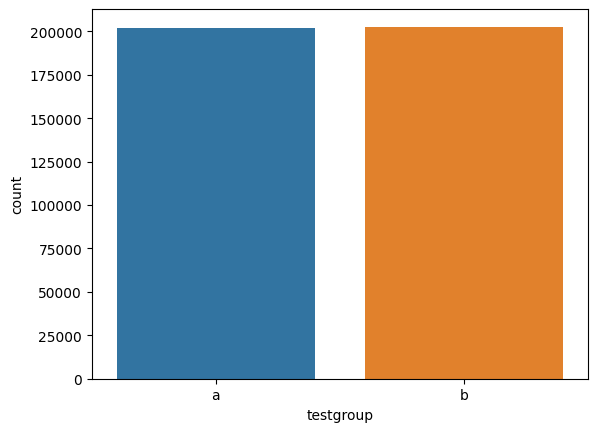

In [19]:
sns.barplot (x="testgroup", y="count", data=group_by_testgroup, hue = 'testgroup')

Из таблицы и графика видно, что количество пользователей практически идентично.

#### 1. Проверим конверсию в покупку.

In [20]:
group_by_purchase_test = df.groupby(['revenue', 'testgroup'], as_index = False).agg({'user_id' : 'count'}) \
    .rename(columns = {'user_id' : 'count'}).sort_values('testgroup').reset_index(drop = True)

In [21]:
group_by_purchase_test

,revenue,testgroup,count
0,0,a,200175
1,369,a,4
2,370,a,11
3,371,a,8
4,372,a,8
...,...,...,...
1473,2711,b,3
1474,2710,b,2
1475,2709,b,4
1476,2716,b,1


In [22]:
# Сделаем дополнительную колонку 1, если revenue > 0, иначе 0

In [23]:
purchases = []
for i in df['revenue']:
    if i == 0:
        x = 0
    else:
        x = 1
    purchases.append(x)
df['purchase'] = purchases
df.head()

,user_id,revenue,testgroup,purchase
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0


In [24]:
# пересчитаем, учитывая новую колонку
group_by_purchase_test = df.groupby(['purchase', 'testgroup'], as_index = False).agg({'user_id' : 'count'}) \
    .rename(columns = {'user_id' : 'count'}).sort_values('testgroup').reset_index(drop = True)
group_by_purchase_test

,purchase,testgroup,count
0,0,a,200175
1,1,a,1928
2,0,b,200862
3,1,b,1805


In [25]:
crosstable = pd.crosstab(df['testgroup'], df['purchase'])
crosstable

purchase,0,1
testgroup,,
a,200175,1928
b,200862,1805


In [26]:
# Проверим статистическую значимость с помощью хи-квадрата

In [27]:
alpha = 0.05
statistic, pvalue, dof, expected_freq = ss.chi2_contingency(crosstable)
pvalue

0.03647561892312613

Т.к.  0.036 < 0.05, нулевую гипотезу отклоняем, т.е. статистическая значимость присутствует

Из анализа можно сделать вывод, что тест предлежения для группы а положительно влиял на пользователей и подталкивал их к совершению покупки 

#### 2. Проверим ARPU и ARPPU

In [28]:
# посчитаем ARPU и ARPPU
arpu_by_group = round(df.groupby('testgroup', as_index = False).agg({'revenue' : 'mean'}), 2)
arppu_by_group = round(df.query('revenue > 0').groupby('testgroup', as_index = False).agg({'revenue' : 'mean'}), 2)

In [29]:
# ARPU по группам
arpu_by_group

,testgroup,revenue
0,a,25.41
1,b,26.75


In [30]:
# ARPPU по группам
arppu_by_group

,testgroup,revenue
0,a,2664.00
1,b,3003.66


In [31]:
# средняя выручка на пользователя и платящего пользователя больше в группе b. Теперь исследуем распределения выручки.

In [32]:
revenue_a = df.query("testgroup == 'a' & revenue > 0")['revenue']
revenue_b = df.query("testgroup == 'b' & revenue > 0")['revenue']

In [33]:
# построим график распределения выручки

(array([1805.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,  123.]),
 array([  200.  ,  2061.65,  3923.3 ,  5784.95,  7646.6 ,  9508.25,
        11369.9 , 13231.55, 15093.2 , 16954.85, 18816.5 , 20678.15,
        22539.8 , 24401.45, 26263.1 , 28124.75, 29986.4 , 31848.05,
        33709.7 , 35571.35, 37433.  ]),
 <BarContainer object of 20 artists>)

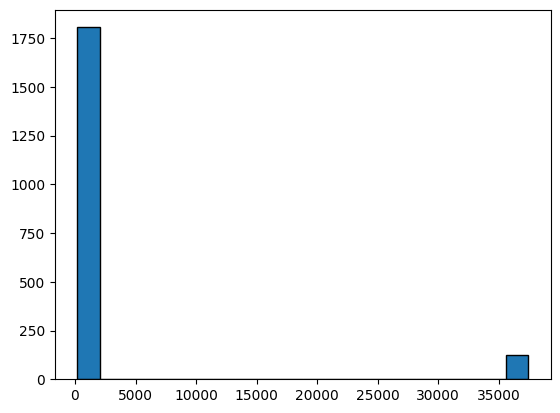

In [34]:
# распределение для выручки группы а
plt.hist (revenue_a, edgecolor='black', bins=20) 

(array([ 92.,  88.,  76.,  96.,  85.,  76., 101., 100.,  86.,  83.,  90.,
         98.,  92.,  96., 121.,  87.,  80.,  82.,  92.,  84.]),
 array([2000., 2100., 2200., 2300., 2400., 2500., 2600., 2700., 2800.,
        2900., 3000., 3100., 3200., 3300., 3400., 3500., 3600., 3700.,
        3800., 3900., 4000.]),
 <BarContainer object of 20 artists>)

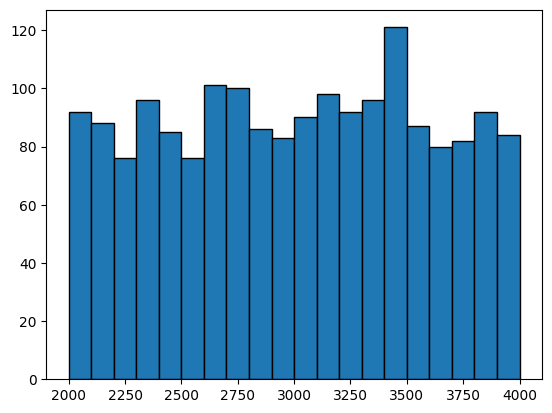

In [35]:
# распределение для выручки группы b
plt.hist (revenue_b, edgecolor='black', bins=20) 

In [36]:
# Посчитаем у каждой группы минимальную, максимальную и медианную выручки
# Для группы а
min_a = df.query("testgroup == 'a' & revenue > 0")['revenue'].min()
max_a = df.query("testgroup == 'a' & revenue > 0")['revenue'].max()
median_a = df.query("testgroup == 'a' & revenue > 0")['revenue'].median()

In [37]:
print('Группа а:')
print('минимальная выручка:') 
print(min_a)
print('максимальная выручка:')
print(max_a)
print('медиана выручки')
print(median_a)

Группа а:
минимальная выручка:
200
максимальная выручка:
37433
медиана выручки
311.0


In [38]:
# Для группы b
min_b = df.query("testgroup == 'b' & revenue > 0")['revenue'].min()
max_b = df.query("testgroup == 'b' & revenue > 0")['revenue'].max()
median_b = df.query("testgroup == 'b' & revenue > 0")['revenue'].median()

In [39]:
print('Группа b')
print('минимальная выручка:') 
print(min_b)
print('максимальная выручка:')
print(max_b)
print('медиана выручки')
print(median_b)

Группа b
минимальная выручка:
2000
максимальная выручка:
4000
медиана выручки
3022.0


Вывод из анализа выручки:

1) в группе b размах выручки гораздо меньше, чем в группе а
2) у пользователей очень сильно различается модель поведения
3) медианная выручка группы b примерно в 10 раз больше медианной выручки группы a

Поскольку наша выборка довольно большая, требование о нормальности распределения мы можем не учитывать. Для определения наличия стат. значимости разницы ARPU, а также ARPPU между группами будем использовать t-test

In [40]:
# ARPU

In [41]:
alpha = 0.05
p = ss.ttest_ind(df.query("testgroup == 'a'")['revenue'], df.query("testgroup == 'b'")['revenue'], 
                    equal_var = False)[1]
p

0.5329647014130866

Т.к. 0.53 > 0.05, то нулевая гипотеза о равенстве средних не отклонена,  то есть t-test показал, что нет статист. значимой разницы между ARPU групп а и b.

In [42]:
# ARPPU

In [43]:
p = ss.ttest_ind(df.query("testgroup == 'a' & revenue > 0")['revenue'], df.query("testgroup == 'b' & revenue > 0")['revenue'], 
                    equal_var = False)[1]
p

0.10020780398916015

Т.к. 0.1 > 0.05, то нулевая гипотеза о равенстве средних не отклонена, то есть t-test показал, что нет статист. значимой разницы между ARPPU групп а и b.

#### После проведения исследования были получены следующие результаты:
1) различия между группами оказали статистически значимое влияние на желание пользователей совершать покупки, т.к. в группе а конверсия больше на 0.06%.
2) у пользователей различное поведение в группах, это следует из того, что выручка пользователей группы b распределена более равномерно в диапазоне от 2000 до 4000, пользователи группы а совершают более дешевые покупки, но есть исключения, которые совершили очень дорогие покупки.
3) различия между группами не оказали статистически значимого влияния на ARPU.
4) различия между группами не оказали статистически значимого влияния на ARPPU.

#### Основываясь на результатах исследования, можно сделать вывод о том, что акционные предложения, использованные в тестовой группе, не имеет смысла распространять на всех пользователей.